# DBSCAN Clustering
    -- density-based spatial clustering of applications with noise (DBSCAN)
    -- is a density-based algorithm that groups together points that are closely packed (high-density areas) and identifies points in low-density areas as noise or outliers.
    -- it does not require the number of clusters to be specified upfront

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

random_s = 101

## Load Data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/renatomaaliw3/public_files/master/Data%20Sets/circles.csv')
df.head(3)


,Feature_1,Feature_2,Label
0,-0.469276,0.210118,1
1,-0.164164,0.986075,0
2,-0.471454,0.019974,1


## Select Features to Cluster

In [ ]:
# Use Feature_1 and Feature_2 only

reduced_df = df.drop('Label', axis = 1)
reduced_df.tail(3)

,Feature_1,Feature_2
497,-0.470806,0.392893
498,-0.103254,-0.560125
499,-0.888650,0.650392


## Visualize the Data

<Axes: xlabel='Feature_1', ylabel='Feature_2'>

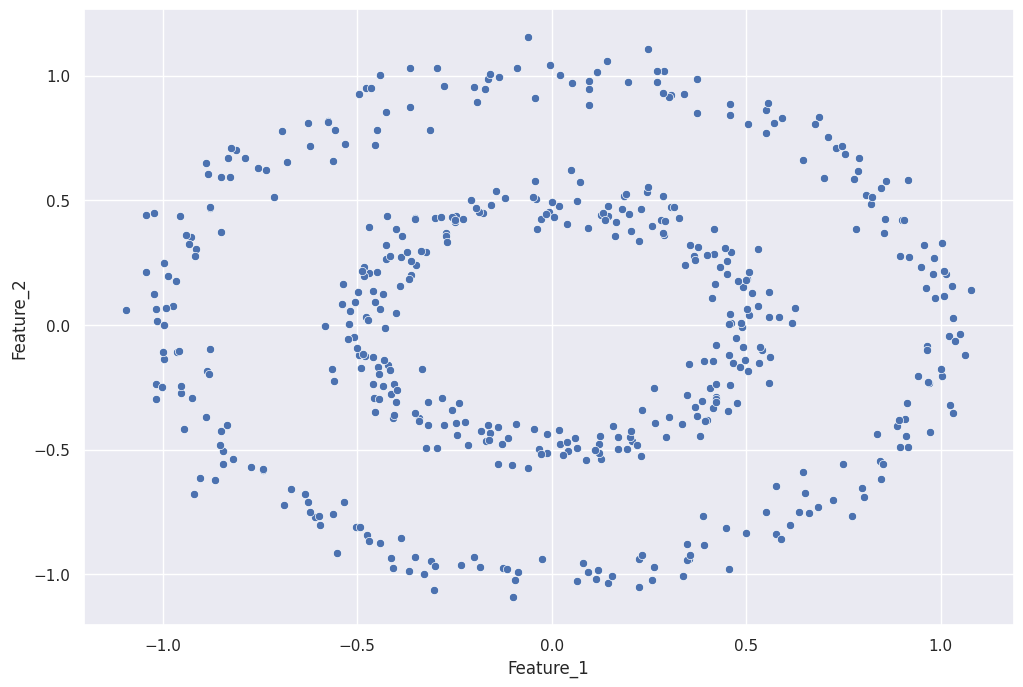

In [ ]:
sns.set(rc = {'figure.figsize': (12, 8)}) # Global Graph Size

sns.scatterplot(x = reduced_df['Feature_1'], y = reduced_df['Feature_2'])

# Use K-Means just for Reference to DBSCAN

In [ ]:
from sklearn.cluster import KMeans

# Apply K-Means clustering

kmeans = KMeans(n_clusters = 2, random_state = random_s)

reduced_df['KMeans Cluster'] = kmeans.fit_predict(reduced_df)
reduced_df.head(3)

,Feature_1,Feature_2,KMeans Cluster
0,-0.469276,0.210118,0
1,-0.164164,0.986075,1
2,-0.471454,0.019974,0


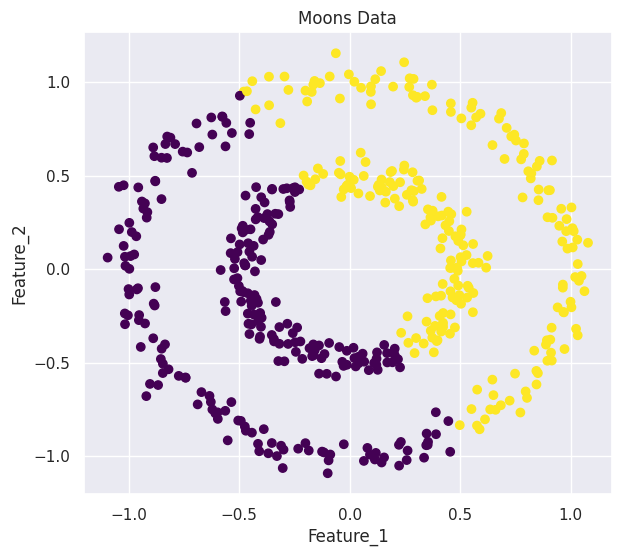

In [ ]:
# Plot K-Means results

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(reduced_df['Feature_1'], reduced_df['Feature_2'], c = reduced_df['KMeans Cluster'], cmap = 'viridis')
plt.title('Moons Data')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.show()

## DBSCAN
    -- density-based spatial clustering of applications with noise (DBSCAN)
    -- is a density-based algorithm that groups together points that are  
       closely packed (high-density areas) and
       identifies points in low-density areas as noise or outliers.
    -- it does not require the number of clusters to be specified upfront

## Understanding the DBSCAN Parameters
    
      -- eps (epsilon): defines the maximum distance between two points for one to be considered as part of the neighborhood of the other
      -- min_samples: minimum number of points required to form a dense regions (core point).
      -- If a pont has a fewer than min_samples within eps, it is labeled as noise or an edge point

In [ ]:
# NOTE:
# One of the best way to select the optimal eps is to use a k-distance graph, which helps to visualize
# the ideal eps value

# FOR eps:
# 1. Compute the distances between each point and its k-th nearest neighbor (typically k = min_samples)
# 2. Sort these distances and plot them. The point where the plot shows an "elbow", a significant
#    bend, is usually a good candidate fro eps.

# FOR min_samples:
# 1. A common rule of thumb for min_samples is to set it to be at least min_samples = 2 * dimensions.
# 2. Increase min_samples if you want fewer but larger clusters and decrease it if you expect many
#    smaller clusters.

# Silhouette Score (S-Score):
# After choosing eps and min_samples, you can evaluate the quality of your clustering using the S-Score,
# which measures how similar each point is to its own cluster compared to other clusters.
# This score ranges from -1 (bad blustering) to +1 (good clustering)

## K-Distance Graph

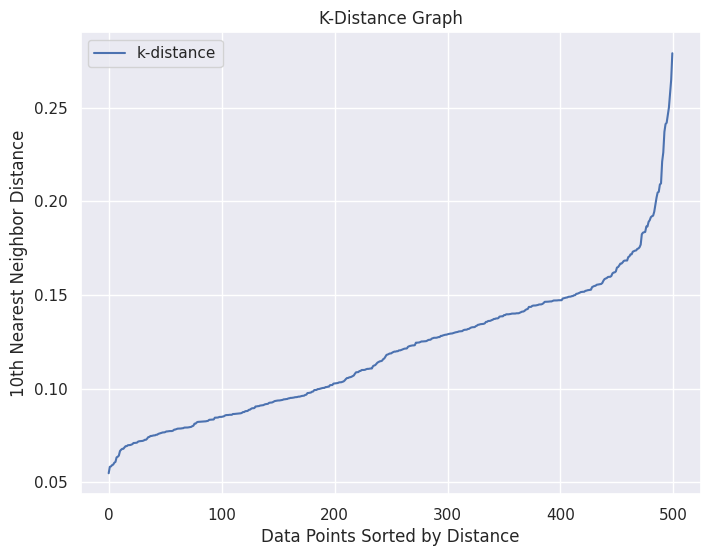

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Compute the K-Nearest Neighbors distances for k = min_samples
# min_samples = 4 (From 2 dimensions or two variables multiplied by 2) - Not absolute but can be a guide

min_samples = 10 # number of neighbors to consider for each point.
                # A point that will be classified as a core point, if it is at least X neighbors within a given radius (eps)

neighbors = NearestNeighbors(n_neighbors = min_samples) # Find the nearest neighbors of a data point
neighbors_fit = neighbors.fit(reduced_df) # fits the NearestNeighbors to your dataset

distances, indices = neighbors_fit.kneighbors(reduced_df) # distances, a matrix where each row contains the distances to the nearest X neighbors for each data point
                                                          # indices, a matrix where each row contains the indices of the nearest 8 neighbors for each data poin

                                                          # In DBSCAN, the eps value determines the maximum distance two points can be considered as neighbors

# Sort the distances (use the k-th nearest neighbor distance for each point)

k_distances = np.sort(distances[:,-1]) # extracts the largest (farthest) distance frome each point to its min_samples-th nearest neighbors
                                       # this is important because a DBSCAN uses this distance to determine whether a point is a core point or not
                                       # sorts the distances to the min_samples-th nearest neighbor in ascending order.

                                       # By sorting the distances, you can see where there’s a sudden jump in the distances,
                                       # which usually indicates a good threshold (eps) for DBSCAN.

# Plot the k-distance graph

plt.figure(figsize = (8,6), facecolor = 'white')
plt.plot(k_distances, label = 'k-distance')
plt.title('K-Distance Graph')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel(f'{min_samples}th Nearest Neighbor Distance')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Looking at the values

# A matrix where each row contains the distances from a given data point to its k nearest neighbors

# k_distances
# distances[:,-1]
# distances
distances


array([[0.        , 0.01991896, 0.02052367, ..., 0.08174658, 0.0833975 ,
        0.0867097 ],
       [0.        , 0.02060163, 0.03089466, ..., 0.11620435, 0.13735988,
        0.14142829],
       [0.        , 0.00201411, 0.01298554, ..., 0.07503448, 0.07690033,
        0.07726389],
       ...,
       [0.        , 0.06571736, 0.07156068, ..., 0.12747337, 0.13527417,
        0.14008613],
       [0.        , 0.03485747, 0.04419803, ..., 0.10622859, 0.11549119,
        0.11610142],
       [0.        , 0.04708369, 0.05800751, ..., 0.10087175, 0.13533092,
        0.15639587]])

## Silhouette Scores (sklearn)

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# Define range of potential eps values based on the k-distance plot

eps_values = np.linspace(0.2, 1.1, 10)

# Store S-Scores

s_scores = []

# Evaluate DBScan for each eps_values and calculate S-Score

for eps in eps_values:

  dbscan = DBSCAN(eps = eps, min_samples = min_samples)  # DBSCAN
  labels = dbscan.fit_predict(reduced_df)

  # Check if the clustering has more than 1 cluster to calculate S-Score
  if len(set(labels)) > 1:

    score = silhouette_score(reduced_df, labels)

  else:

    score = -1  # Invalid clustering scenario

  s_scores.append(score)

In [ ]:
# Look at s_scores
s_scores

[0.195588422751394,
 0.5144998355128827,
 0.5144998355128827,
 0.5144998355128827,
 0.5144998355128827,
 0.5144998355128827,
 0.5144998355128827,
 0.5144998355128827,
 0.5144998355128827,
 -1]

In [ ]:
# BIG NOTE:

# While DBSCAN can find non-spherical clusters, the Silhouette Score doesn't always perfectly capture the quality of
# these clusters because it is designed for more convex clusters (like those K-Means would find).
# Thus, it may overestimate the quality of a more coarse clustering at higher eps values.

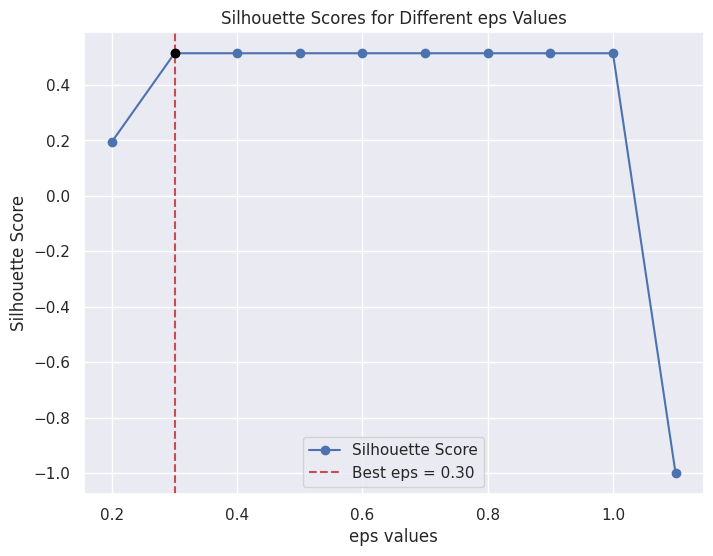

In [ ]:
# Plot the S-Scores

# Plot the Silhouette Scores for different eps values

plt.figure(figsize=(8, 6))

# Plot silhouette scores for each eps value

plt.plot(eps_values, s_scores, marker='o', label='Silhouette Score')

# Add labels and title
plt.title('Silhouette Scores for Different eps Values')
plt.xlabel('eps values')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Highlight the best eps

best_eps_index = np.argmax(s_scores) # find the index of the best s_score
best_eps = eps_values[best_eps_index] # this will the best eps
best_s_score = s_scores[best_eps_index] # this will be the best s_score

plt.axvline(x = best_eps, color='r', linestyle='--', label = f'Best eps = {best_eps:.2f}')
plt.scatter(best_eps, best_s_score, color='black', zorder = 5)
plt.legend()
plt.show()

## Final DBSCAN Model

In [ ]:
# Define DBSCAN model

final_model = DBSCAN(eps = 0.25, min_samples = 4)

# Fit the model to the scaled dataset

db_scan_clusters = final_model.fit_predict(reduced_df.iloc[:,:2])

# Add the cluster labels to the scaled DataFrame

reduced_df['DBSCAN Cluster'] = db_scan_clusters
reduced_df.head(3)

,Feature_1,Feature_2,KMeans Cluster,DBSCAN Cluster
0,-0.469276,0.210118,0,0
1,-0.164164,0.986075,1,1
2,-0.471454,0.019974,0,0


## Visualized the Clusters

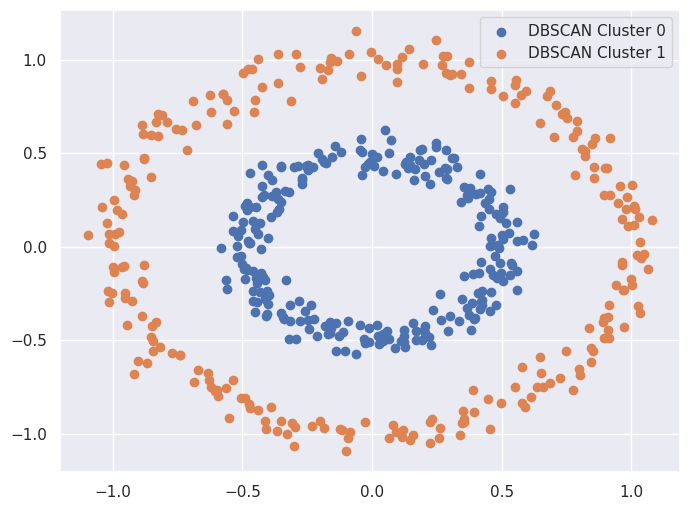

In [ ]:
# Plotting the clusters

plt.figure(figsize=(8,6))

# Scatter plot for the DBSCAN clusters

# Get the unique clusters

unique_clusters = reduced_df['DBSCAN Cluster'].unique()

# Scatter plot for each cluster with labels

for cluster in unique_clusters:

    cluster_data = reduced_df[reduced_df['DBSCAN Cluster'] == cluster]

    plt.scatter(cluster_data['Feature_1'],
                cluster_data['Feature_2'],
                label=f'DBSCAN Cluster {cluster}', marker='o')


# Display the legend
plt.legend()

# Show the plot
plt.show()